# 1. PERKENALAN

=======================================================================================================================================================================================================================


Tujuan         : Project ini bertujuan untuk memprediksi kualitas udara kota di India, apakah memiliki kualitas udara yang bagus atau buruk. Akan dipilih 1 model terbaik diantara 5 model pilihan yang nantinya digunakan untuk memprediksi kualitas udara kota di India.


=======================================================================================================================================================================================================================

Latar belakang:

Urgensi mengapa dilakukan prediksi kualitas udara kota-kota di India yaitu untuk mengatasi dampak serius dari kesalahan prediksi yang menyebabkan kualitas udara terlihat lebih baik daripada yang sebenarnya. Ketidakakuratan semacam itu berpotensi menghambat kebijakan pengelolaan lingkungan dan kesehatan masyarakat, karena otoritas dapat kesulitan mengambil tindakan preventif atau pencegahan yang tepat ketika kualitas udara sebenarnya buruk. Dalam situasi dimana banyak prediksi menunjukkan kondisi udara yang baik, padahal sebaliknya (buruk), risiko kesehatan masyarakat dapat terabaikan. Oleh karena itu, diperlukan pemahaman mendalam tentang pola dan tren dalam data kualitas udara, termasuk parameter-parameter kunci seperti PM2.5, PM10, NO, NO2, CO, dan parameter lainnya. Analisis ini bertujuan untuk mengembangkan model prediktif yang lebih akurat, mengurangi kesalahan prediksi positif, dan mendukung implementasi kebijakan pengelolaan lingkungan yang lebih efisien.

# 2. IMPORT LIBRARIES

In [64]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats

# Untuk kebutuhan visual
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Untuk feature engineering
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, kendalltau
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline

# Untuk kebutuhan model linear regresi
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Untuk kebuthan model evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

# Untuk kebutuhan cek VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Untuk kebutuhan scale dan encod data
from sklearn.preprocessing import LabelEncoder, StandardScaler , OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn import preprocessing

# Untuk handling imbalance
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Untuk kebutuhan handling outlier
from feature_engine.outliers import Winsorizer

# Untuk saving model, scaler dan encoder
import pickle
import json
import joblib

import warnings
warnings.filterwarnings('ignore')

np.random.seed(5)

# 3. LOADING DATA

In [65]:
# Load data
raw_data = pd.read_csv('city_day.csv')

# Menampilkan data
raw_data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory


Dataset memiliki 29.531 rows dan 16 kolom.

In [66]:
# Duplikat dataframe
eda_data = raw_data.copy()

In [67]:
raw_data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


In [68]:
# Menampilkan informasi data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


Pada dataset memiliki 29.531 data dan 16 kolom. Adapun 13 kolom dengan tipe data float dan 3 kolom dengan tipe data object. Terlihat terdapat beberapa kolom yang memiliki missing value.

## 3.1 Cek Target 'AQI_Bucket'

AQI_Bucket
Moderate        8829
Satisfactory    8224
Poor            2781
Very Poor       2337
Good            1341
Severe          1338
Name: count, dtype: int64

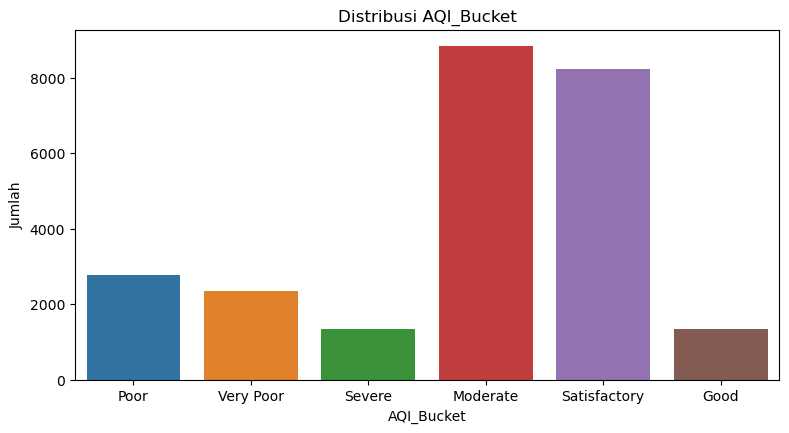

In [69]:
# Membuat canvas untuk visualisasi
plt.figure(figsize=(20, 10))

# Membuat bar chart
plt.subplot(2,2,1)
ax1 = sns.countplot(data=raw_data, x='AQI_Bucket')
ax1.set_ylabel('Jumlah')
ax1.set_title('Distribusi AQI_Bucket')
raw_data['AQI_Bucket'].value_counts()

Pada kolom target terdapat 6 kategori Air Quality Index (AQI), yaitu 'Poor', 'Very Poor', 'Severe', 'Moderate', 'Satisfactory', dan 'Good'. Adapun kategori target terbanyak yaitu 'Moderate' dengan jumlah 8.829, selanjutnya 'Satisfactory' sebanyak 8.824, kemudian 'Poor' sebanyak 2.781, 'Very Poor' dengan jumlah 2.337, 'Good dengan jumlah 1.341, dan terakhir 'Severe' sebanyak 1.338.

Dengan alasan agar model yang dihasilkan lebih sederhana dan mudah diinterpretasikan, dan juga adanya ketidakseimbangan kelas di antara enam kategori, saya mengompres target menjadi dua kategori ('Good' dan 'Poor') sehingga membantu mengatasi masalah ketidakseimbangan kelas dan meningkatkan kinerja model.

Adapun cara untuk compress menjadi 2 target yaitu sebagai berikut:
- Ketgori 'Poor', 'Very Poor', dan 'Severe' akan dijadikan 1 target. 
- Kategori 'Satisfactory' dan 'Good' akan dihapus.
- Kategori 'Moderate' diganti menjadi 'Good'.

Target final:
- 'Poor'
- 'Good'

In [70]:
# Menggabungkan kategori 'Poor', 'Very Poor', dan 'Severe'
raw_data['AQI_Bucket'] = raw_data['AQI_Bucket'].replace({'Very Poor': 'Poor', 'Severe': 'Poor'})

In [71]:
# Menghapus kategori 'Satisfactory' dan 'Good'
indices_to_drop = raw_data[raw_data['AQI_Bucket'].isin(['Satisfactory', 'Good'])].index


In [72]:
raw_data = raw_data.drop(indices_to_drop)


In [73]:
# Mengganti kategori 'Moderate' menjadi 'Good'
raw_data['AQI_Bucket'] = raw_data['AQI_Bucket'].replace({'Moderate': 'Good'})

## Visualisasi Target 'AQI_Bucket' Final

AQI_Bucket
Good    8829
Poor    6456
Name: count, dtype: int64

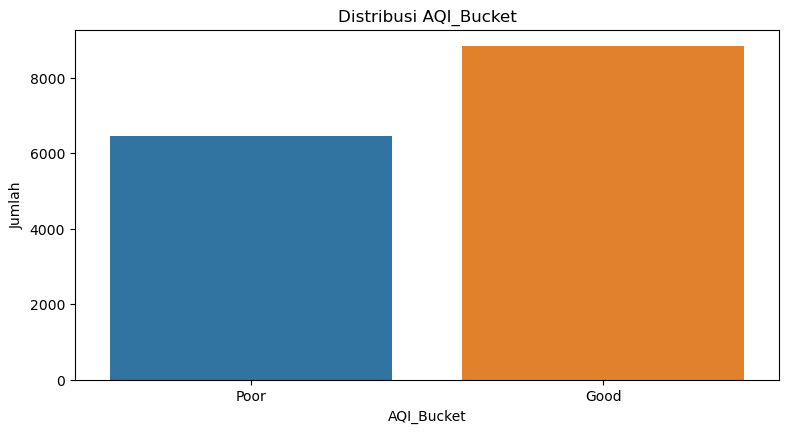

In [74]:
# Membuat canvas untuk visualisasi
plt.figure(figsize=(20, 10))

# Membuat bar chart
plt.subplot(2,2,1)
ax1 = sns.countplot(data=raw_data, x='AQI_Bucket')
ax1.set_ylabel('Jumlah')
ax1.set_title('Distribusi AQI_Bucket')
raw_data['AQI_Bucket'].value_counts()

Dapat dilihat dari visualisasi target 'AQI_Bucket' di atas, bahwa kategori sudah menjadi binary antara 'Poor' dan 'Good'. Kategori 'Good' memiliki jumlah sebanyak 8.829 dan 'Poor' sebanyak 6.456.

## 3.2 Cek Missing Value

In [75]:
# Cek missing value
raw_data.isnull().sum()

City              0
Date              0
PM2.5          4337
PM10           9403
NO             3392
NO2            3431
NOx            3667
NH3            8808
CO             1903
SO2            3655
O3             3609
Benzene        3973
Toluene        5512
Xylene        11612
AQI            4681
AQI_Bucket     4681
dtype: int64

Dari informasi di atas diketahui bahwa hanya kolom 'City' dan 'Date' yang tidak memiliki missing value. Berikutnya kita akan mencari persentase missing value dari tiap kolom sehingga dapat ditentukan cara handling missing valuenya.

In [76]:
# Persentase missing value
raw_data.isnull().sum() / len(raw_data) * (100)

City           0.000000
Date           0.000000
PM2.5         21.721927
PM10          47.095062
NO            16.988881
NO2           17.184213
NOx           18.366223
NH3           44.114995
CO             9.531203
SO2           18.306120
O3            18.075729
Benzene       19.898828
Toluene       27.606932
Xylene        58.158870
AQI           23.444856
AQI_Bucket    23.444856
dtype: float64

Pada informasi di atas diketahui persentasenya missing value tiap kolom pada dataset, adapun cara handling missing value yaitu sebagai berikut:
- Kolom 'CO' merupakan satu-satunya kolom dengan persentase dibawah 10% maka dari itu handling missing value pada kolom ini dengan cara imputasi dengan nilai median kolom 'CO', hal ini dikarenakan tidak akan banyak merubah distribusi data asli.

- Kolom 'Xylene', 'PM10', dan 'NH3' merupakan kolom dengan persentase missing value diatas 40% dimana sangat besar, maka dari itu cara handling missing valuenya dengan drop/menghapus kolom tersebut. Hal ini dikarenakan menghapus kolom yang memiliki persentase missing value tinggi dapat meningkatkan konsistensi dan keandalan dataset. Dan apabila dilakukan imputasi dapat mengenakan dampak yang signifikan pada distribusi data dan statistik. Pengisian nilai mungkin menghasilkan bias yang tidak diinginkan.

- Kolom-kolom sisa yang memiliki missing value akan dilakukan handling missing value dengan cara dropna atau hapus missing value.

### Handling Missing Value CO

In [77]:
# Mengetahui presentase dari missing values kolom CO
raw_data['CO'].isnull().sum() / len(raw_data['CO']) * (100/100)

0.095312030451768

In [78]:
# Median data kolom CO
raw_data['CO'].median()

1.09

In [79]:
# Imputasi (filna) missing value data CO dengan nilai median
raw_data['CO'] = raw_data['CO'].fillna(raw_data['CO'].median())

### Handling Missing Value 'PM10', 'NH3', 'Xylene'

In [80]:
# Drop kolom dengan persentase missing value diatas 40% ('PM10', 'NH3', 'Xylene')
raw_data.drop(['PM10', 'NH3', 'Xylene'], axis=1, inplace=True)

### Handling Missing Value Kolom Lain

In [81]:
# Hapus missing value dari kolom lain
raw_data = raw_data.dropna()

### Cek Missing Value Setelah di Handling Missing Value

In [82]:
# Cek missing value setelah handling missing value
raw_data.isnull().sum() / len(raw_data) * (100)

City          0.0
Date          0.0
PM2.5         0.0
NO            0.0
NO2           0.0
NOx           0.0
CO            0.0
SO2           0.0
O3            0.0
Benzene       0.0
Toluene       0.0
AQI           0.0
AQI_Bucket    0.0
dtype: float64

Setelah dilakukan handling missing value, pada dataset sudah tidak memiliki missing value lagi.

## 3.3 Cek Data Duplikat

In [83]:
raw_data.duplicated().sum()

0

Pada dataset tidak memiliki data duplikat.

In [84]:
# Riset index
raw_data = raw_data.reset_index(drop=True)

In [85]:
# Menampilkan informasi data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10823 entries, 0 to 10822
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        10823 non-null  object 
 1   Date        10823 non-null  object 
 2   PM2.5       10823 non-null  float64
 3   NO          10823 non-null  float64
 4   NO2         10823 non-null  float64
 5   NOx         10823 non-null  float64
 6   CO          10823 non-null  float64
 7   SO2         10823 non-null  float64
 8   O3          10823 non-null  float64
 9   Benzene     10823 non-null  float64
 10  Toluene     10823 non-null  float64
 11  AQI         10823 non-null  float64
 12  AQI_Bucket  10823 non-null  object 
dtypes: float64(10), object(3)
memory usage: 1.1+ MB


Jumlah data pada dataset berkurang menjadi 10.823 yang dari awalnya sebanyak 29.531. Jumlah kolom dataset juga berubah menjadi 13 kolom, dengan 10 kolom dengan tipe data float dan 3 kolom bertipe data object.

# 4. EXPLORATORY DATA ANALYSIS (EDA) 1

## 4.1 Perbandingan Kualitas Udara Antar Kota di India

[Text(0, 0, '452.123'),
 Text(0, 0, '34.7658'),
 Text(0, 0, '95.2996'),
 Text(0, 0, '119.921'),
 Text(0, 0, '94.3183'),
 Text(0, 0, '132.827'),
 Text(0, 0, '150.281'),
 Text(0, 0, '96.4983'),
 Text(0, 0, '114.503'),
 Text(0, 0, '73.0233'),
 Text(0, 0, '259.488'),
 Text(0, 0, '92.3595'),
 Text(0, 0, '225.124'),
 Text(0, 0, '140.111'),
 Text(0, 0, '109.207'),
 Text(0, 0, '133.679'),
 Text(0, 0, '159.252'),
 Text(0, 0, '104.285'),
 Text(0, 0, '140.566'),
 Text(0, 0, '217.973'),
 Text(0, 0, '105.352'),
 Text(0, 0, '240.782'),
 Text(0, 0, '53.7951'),
 Text(0, 0, '172.887'),
 Text(0, 0, '75.8783'),
 Text(0, 0, '117.27')]

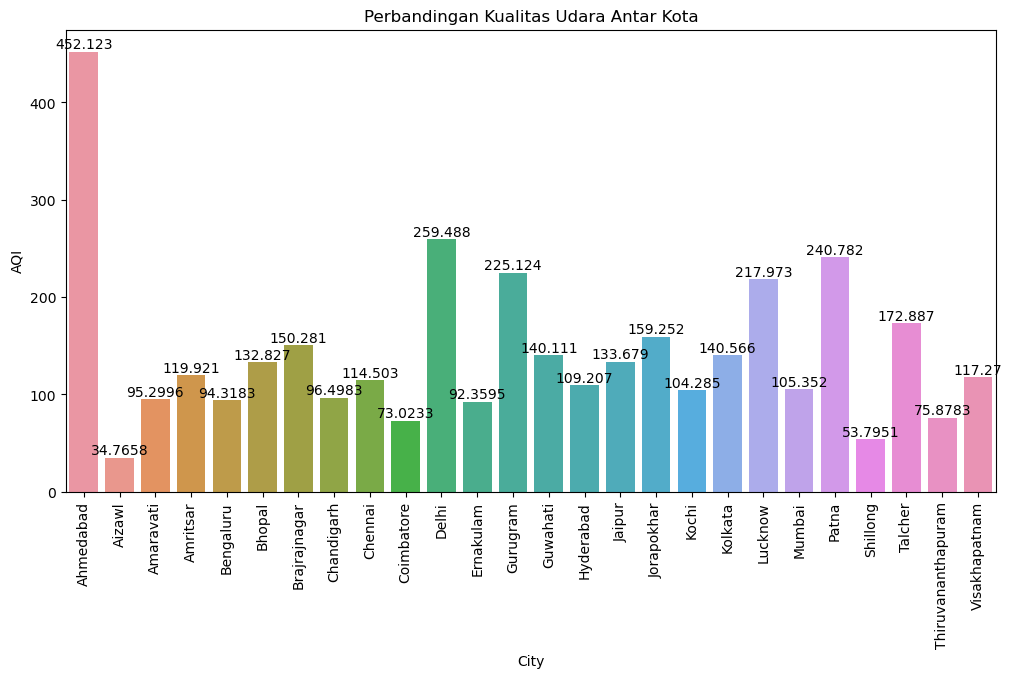

In [86]:
# Fungsi untuk visualisasi Perbandingan KUalitas Udara Antar Kota di India
fig,ax=plt.subplots(figsize=(12, 6))
sns.barplot(x='City', y='AQI', data=eda_data, ci=None)
plt.title('Perbandingan Kualitas Udara Antar Kota')
plt.xticks(rotation=90)
plt.bar_label(ax.containers[0], label_type='edge')

Berdasarkan nilai Air Quality Index (AQI), kota dengan kualitas udara yang paling buruk yaitu Ahmedabad dan kota dengan kualitas udara paling bagus yaitu Aizawl. Adapun urutan 5 kota dengan kualitas udara terbaik yaitu Aizawl, Shillong, Coimbatore, Thiruvananthapuram, dan Ernakulam. Untuk urutan 5 kota dengan kualitas udara terburuk yaitu Ahmedabad, Delhi, Patna, Gurugram, dan Lucknow.

## 4.2 Parameter PM2.5 Dari Waktu ke Waktu

Text(0, 0.5, 'PM2.5')

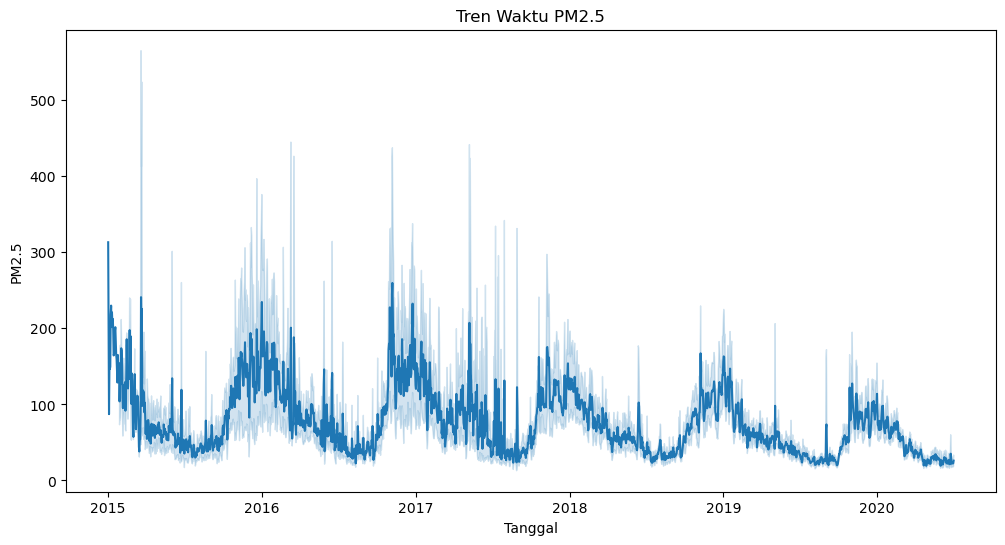

In [87]:
# Fungsi untuk visualisasi Trend Parameter PM2.5 dari Waktu ke Waktu
eda_data['Date'] = pd.to_datetime(eda_data['Date'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='PM2.5', data=eda_data)
plt.title('Tren Waktu PM2.5')
plt.xlabel('Tanggal')
plt.ylabel('PM2.5')

Parameter PM2.5 memiliki pergerakan yang stabil dengan trend stationary dari tahun ke tahun.

## 4.3 Korelasi Antar Parameter Pencemaran Udara

Text(0.5, 1.0, 'Korelasi Antar Parameter Pencemaran Udara')

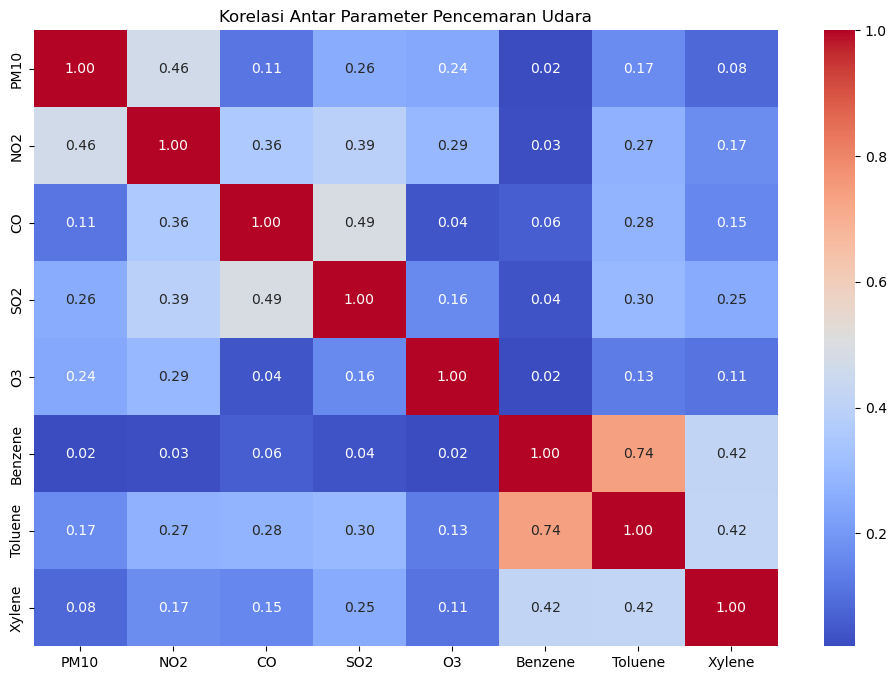

In [88]:
# Fungsi untuk visualisasi Hubungan Antar Parameter Pencemaran Udara
plt.figure(figsize=(12, 8))
corr_matrix = eda_data[['PM10', 'NO2', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Parameter Pencemaran Udara')

Dari gambar heatmap di atas diketahui bahwa Toluene dan Benzene memiliki korelasi antar parameter pencemar udara yang cukup tinggi yaitu sebesar 0.74, sedangkan pada Benzene dan O3 memiliki korelasi antar parameter pencemar udara yang sangat kecil yaitu 0.02.

## 4.4 Perubahan Kualitas Udara Seiring Waktu

Text(0, 0.5, 'AQI')

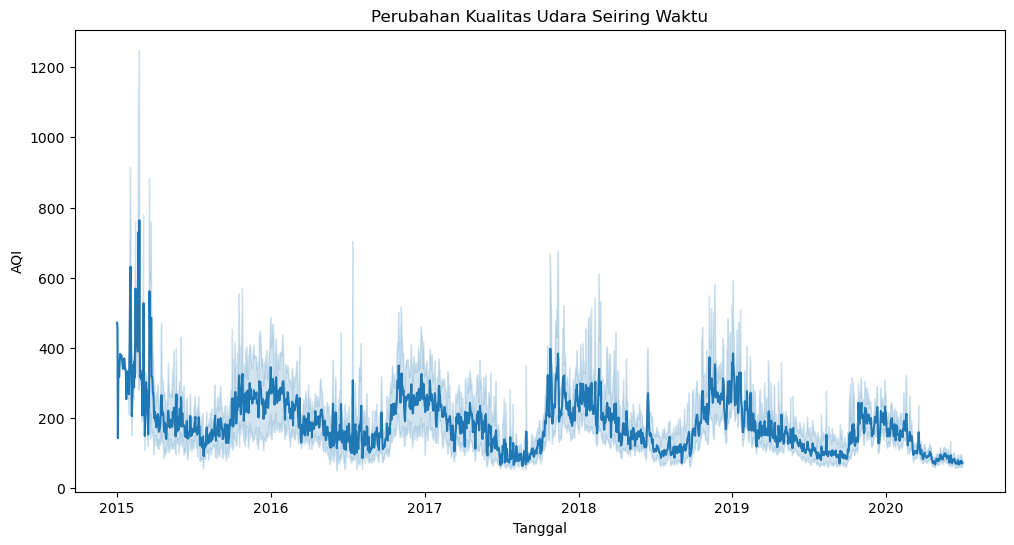

In [89]:
# Fungsi untuk visualisasi Perubahan Kualitas Udara Seiring Waktu
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='AQI', data=eda_data)
plt.title('Perubahan Kualitas Udara Seiring Waktu')
plt.xlabel('Tanggal')
plt.ylabel('AQI')

Pada tahun 2015 kualitas udara di India sempat menjadi yang paling buruk diantara tahun lainnya, dan pada tahun 2015 juga terjadi kenaikan kualitas udara yang signifikan.

# 4.5 Persentase Parameter CO Terhadap Target

[Text(0, 0, '1.23447'), Text(0, 0, '6.80062')]

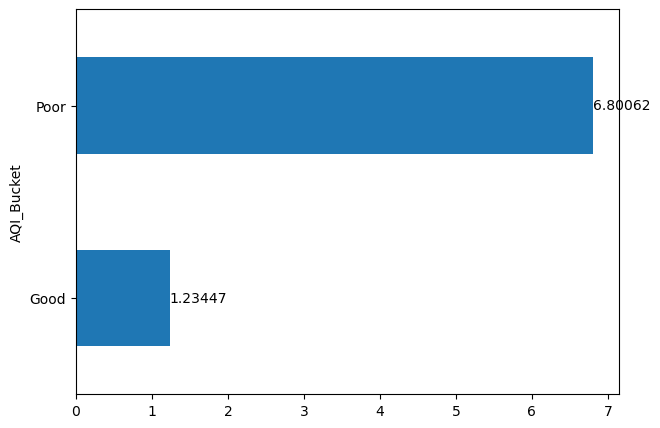

In [90]:
# Fungsi untuk visualisasi Persentase CO Terhadap Target
fig,ax=plt.subplots(figsize=(7, 5))
raw_data.groupby('AQI_Bucket')['CO'].mean().plot.barh()
plt.bar_label(ax.containers[0], label_type='edge')

Pada kategori Poor, parameter CO memiliki rata-rata paling tinggi yaitu sebesar 6.80062 dan pada kategori Good memiliki rata-rata sebesar 1.23447.

## 4.6 Proporsi Data Target 'AQI_Bucket'

AQI_Bucket
Good    5956
Poor    4867
Name: count, dtype: int64

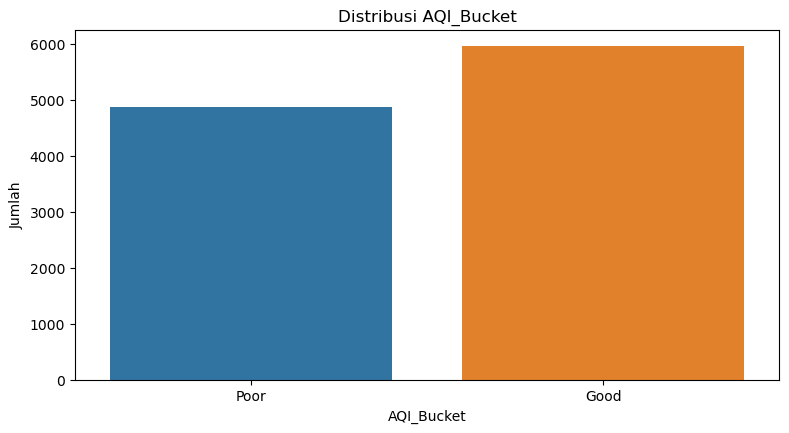

In [91]:
# Membuat canvas untuk visualisasi
plt.figure(figsize=(20, 10))

# Membuat bar chart
plt.subplot(2,2,1)
ax1 = sns.countplot(data=raw_data, x='AQI_Bucket')
ax1.set_ylabel('Jumlah')
ax1.set_title('Distribusi AQI_Bucket')
raw_data['AQI_Bucket'].value_counts()

Proporsi target 'Good' lebih banyak daripada target 'Poor'. Jumlah target 'Good' sebanyak 5.956 dan target 'Poor' sebanyak 4.867.

# 5. FEATURE ENGINEERING

In [92]:
# Duplikat data untuk feature engineering
df = raw_data.copy()

In [93]:
# Menampilkan jumlah tiap target
df['AQI_Bucket'].value_counts()

AQI_Bucket
Good    5956
Poor    4867
Name: count, dtype: int64

Target Good memiliki jumlah yang lebih banyak yaitu 5.956, sedangkan target Poor memiliki jumlah sebanyak 4.867. Angka tersebut menunjukkan bahwa data target tidak balance (imbalance).

In [94]:
# Menggantikan nilai AQI_Bucket menjadi good = 1 dan poor = 0
df['AQI_Bucket'] = df['AQI_Bucket'].map({'Good': 1, 'Poor': 0})

# Menampilkan data setelah mapping
df['AQI_Bucket']

0        0
1        0
2        0
3        0
4        0
        ..
10818    1
10819    1
10820    1
10821    1
10822    1
Name: AQI_Bucket, Length: 10823, dtype: int64

## 5.2 Cek Korelasi

### Korelasi Kolom Numerikal

<Axes: >

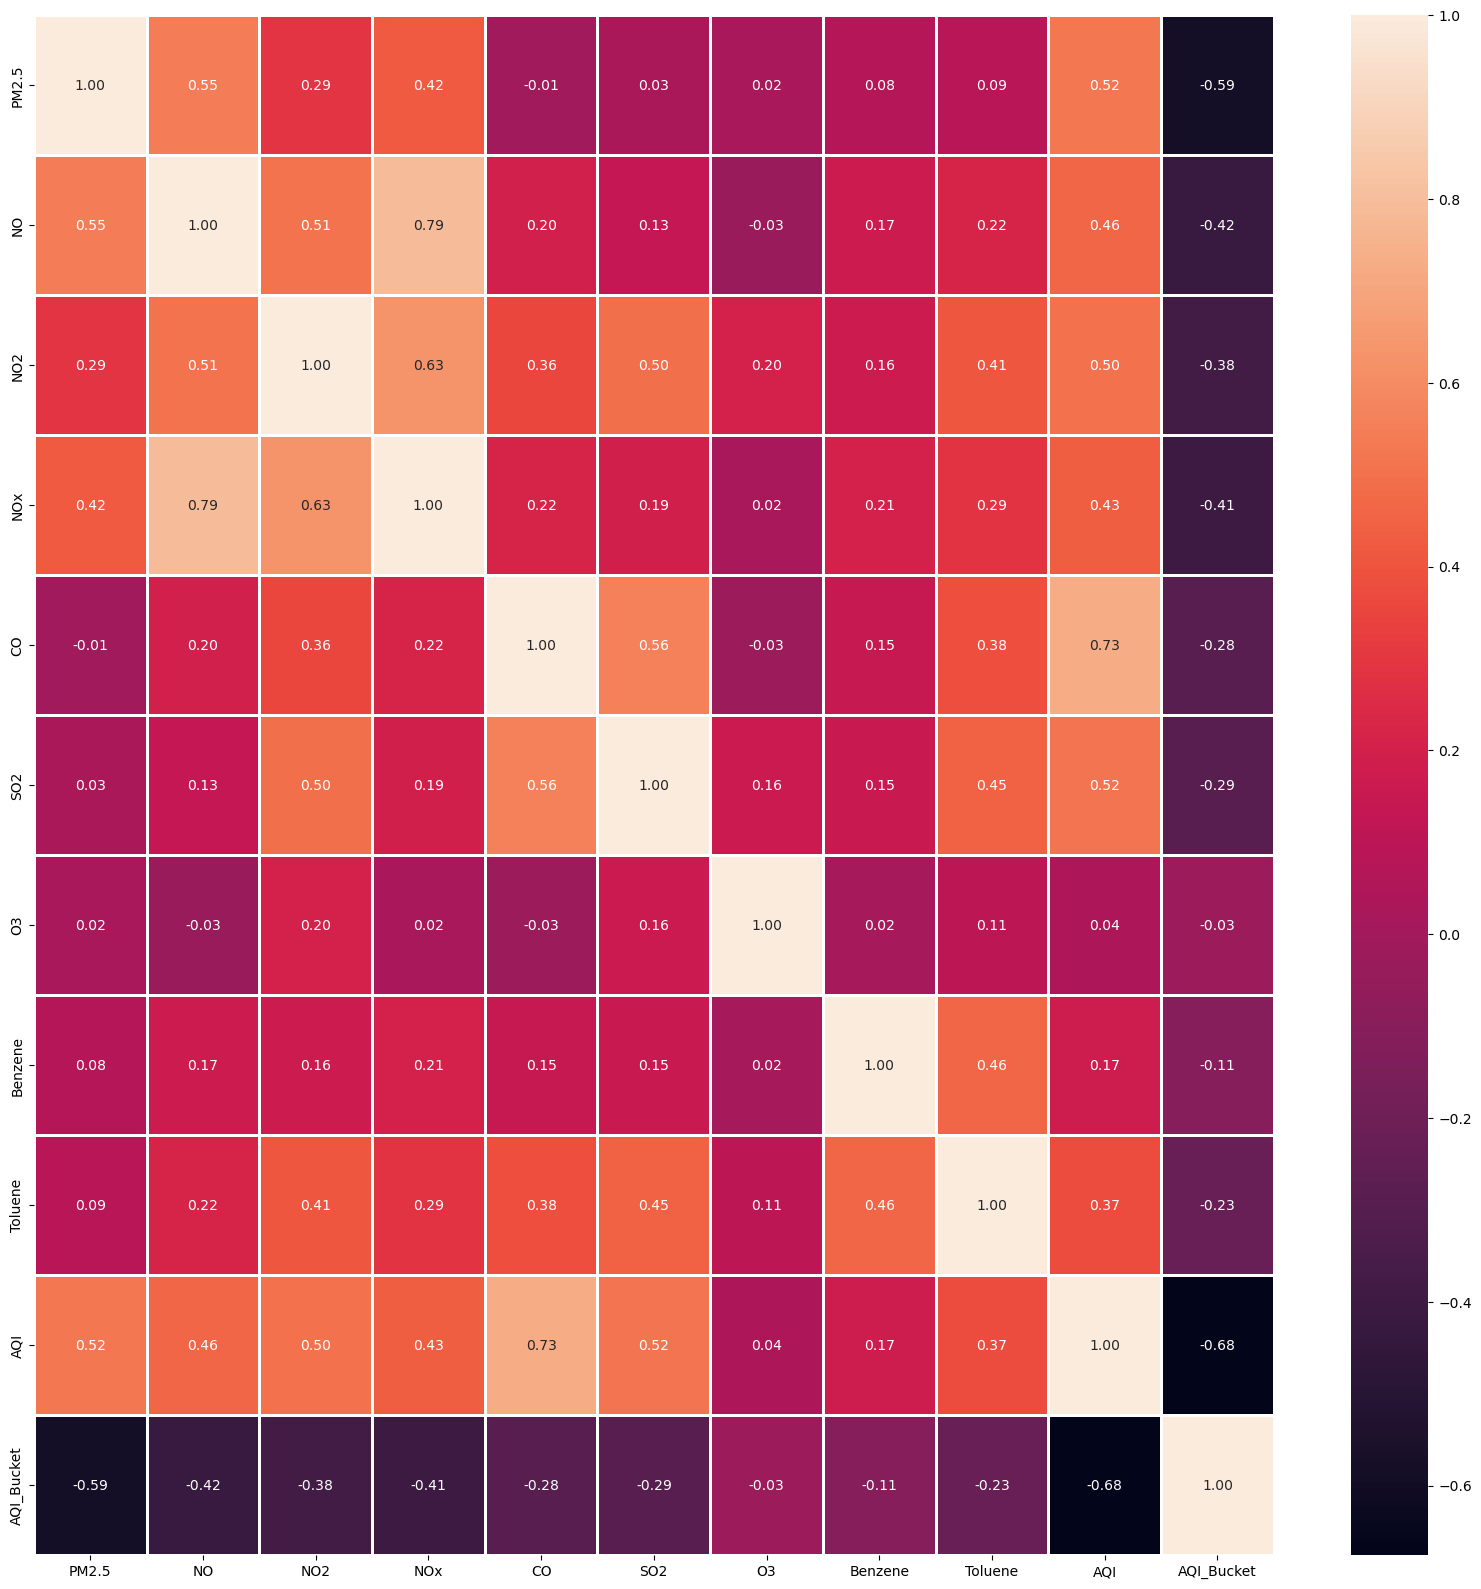

In [95]:
num_corr = df[['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI', 'AQI_Bucket']]
cat_corr = df[['City']]

# Melakukan plot weather_cols menggunakan heatmap
plt.figure(figsize=(20, 20)) # Mengatur ukuran figure
sns.heatmap(num_corr.corr(method='pearson'), annot=True, fmt=".2f",linewidths="1") # Menggunakan korelasi pearson

Kolom O3 dan Benzene memiliki nilai korelasi yang kecil sehingga tidak akan digunakan untuk feature selection. Alasan menghapus kolom O3 dan Benzene yaitu nilai korleasi yang sangat kecil tidak memberikan kontribusi signifikan dalam menjelaskan variasi dalam 'AQI_bucket' dan tidak ada hubungan yang kuat antara keduanya.

### Korelasi Kolom Kategorikal

In [96]:
# Cek nilai korelasi kolom ketgorikal
for i in cat_corr:
     
    corr, pval = stats.kendalltau(df[i],df['AQI_Bucket'])
    print(f"{i} dengan AQI_Bucket")
    print(f"Nilai korelasi :{corr}")
    if pval < 0.05:
        print(f"P-value :{pval}")
    else:
        print(f"P-value :{pval}")

    print()

City dengan AQI_Bucket
Nilai korelasi :0.07093686888493252
P-value :5.034549819769305e-18



Kolom City memiliki nilai korelasi yang sangat kecil, sehingga tidak akan digunakan untuk feature.

Hasil feature selection yang akan digunakan:
1. PM2.5 dengan nilai korelasi -0.59 terhadap target
2. NO dengan nilai korelasi -0.42 terhadap target
3. NO2 dengan nilai korelasi -0.38 terhadap target
4. NOx dengan nilai korelasi -0.41 terhadap target
5. CO dengan nilai korelasi -0.28 terhadap target
6. SO2 dengan nilai korelasi -0.29 terhadap target
7. Toluene dengan nilai korelasi -0.23 terhadap target
8. AQI dengan nilai korelasi -0.68 terhadap target

Nilai negatif dikarenakan semakin tinggi nilai parameter maka semakin tinggi nilai Air Quality Index (AQI), dan semakin tinggi nilai AQI maka semakin buruk kualitas udara nya (AQI_bucket). Berarti nilai negatif pada konteks ini yaitu semakin tinggi nilai suatu parameter pencemar udara, maka semakin rendah(buruk) kualitas udara.

## 5.3 Slicing

In [97]:
# Pembuatan data frame baru yang berisikan seleksi dari feature yang diambil
df_final = df[['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'AQI', 'AQI_Bucket']]
df_final.head(10)

,PM2.5,NO,NO2,NOx,CO,SO2,AQI,AQI_Bucket
0,83.13,6.93,28.71,33.72,6.93,49.52,209.0,0
1,79.84,13.85,28.68,41.08,13.85,48.49,328.0,0
2,94.52,24.39,32.66,52.61,24.39,67.39,514.0,0
3,135.99,43.48,42.08,84.57,43.48,75.23,782.0,0
4,178.33,54.56,35.31,72.80,54.56,55.04,914.0,0
5,139.70,30.61,28.40,56.73,30.61,33.79,660.0,0
6,80.65,2.37,22.83,24.00,2.37,25.73,294.0,0
7,58.36,2.60,21.39,23.31,2.60,32.66,149.0,1
8,79.29,1.16,26.94,26.83,1.16,67.41,190.0,1
9,88.70,7.29,31.32,37.73,7.29,80.09,247.0,0


## 5.4 Cardinality

In [98]:
# Cek Cardinality

for i in df_final:
    print("Cardinality pada variable ",i,": {}".format(len(df_final[i].unique())))

Cardinality pada variable  PM2.5 : 7679
Cardinality pada variable  NO : 4692
Cardinality pada variable  NO2 : 6018
Cardinality pada variable  NOx : 6213
Cardinality pada variable  CO : 1495
Cardinality pada variable  SO2 : 3753
Cardinality pada variable  AQI : 715
Cardinality pada variable  AQI_Bucket : 2


Hasil perhitungan nilai kardinalitas di atas menunjukkan bahwa feature numerik memiliki kardinalitas yang tinggi (High Cardinality).

## 5.5 Splitting

In [99]:
# Memisahkan kolom AQI_bucket untuk y (target)
X = df_final.drop('AQI_Bucket', axis =1)
y = df_final['AQI_Bucket']

# Membagi data menjadi data latih dan data uji dengan test_size 30% dan random_state 0
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

# Menampilkan ukuran data latih dan data uji
print('Train size : ', X_train.shape)
print('Test size : ', X_test.shape)

Train size :  (7576, 7)
Test size :  (3247, 7)


Besar ukuran train yaitu 7.576 rows dan 7 kolom, sedangkan untuk test yaitu 3.247 rows dam 7 kolom. Hal ini dikarenakan pembagian persentase untuk train dan test yaitu 70:30.

## 5.6 Multicollineartity (VIF)

Multikolinieritas terjadi ketika dua atau lebih variabel independen dalam model regresi memiliki hubungan kuat satu sama lain. Korelasi yang kuat antar variabel dapat menyebabkan ketidakstabilan dan ambiguitas dalam estimasi koefisien regresi.

In [100]:
# Function untuk mengecek nilai multicollinearity
def calc_vif(X):

    # Kalkulasi VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
# Cek multicollinearity
calc_vif(X_train)

,variables,VIF
0,PM2.5,8.353592
1,NO,5.497484
2,NO2,6.496077
3,NOx,8.076092
4,CO,4.523891
5,SO2,3.183284
6,AQI,16.607551


Variabel AQI memiliki nilai VIF yang sangat tinggi, artinya variabel tersebut memiliki korelasi antar variabel yang kuat. Maka dari itu akan dilakukan drop variabel VIF.

In [101]:
# Drop feature AQI
X_train = X_train.drop('AQI', axis=1)

# Menampilkan nilai multicollinearity setelah drop AQI
calc_vif(X_train)

,variables,VIF
0,PM2.5,3.136712
1,NO,5.464272
2,NO2,6.260499
3,NOx,8.003724
4,CO,1.808881
5,SO2,3.035841


Setelah dilakukan drop variabel AQI, nilai beberapa variabel masih tinggi seperti variabel NOx dengan nilai VIF 8.003724. Maka dari itu selanjutnya akan dilakukan drop variabel NOx.

In [102]:
# Drop feature NOx
X_train = X_train.drop('NOx', axis=1)

# Menampilkan nilai multicollinearity setelah drop NOx
calc_vif(X_train)

,variables,VIF
0,PM2.5,3.126796
1,NO,3.185308
2,NO2,4.523871
3,CO,1.808878
4,SO2,3.016197


Setelah dilakukan drop variabel NOx, nilai VIF tiap variabel sudah kurang dari 5 dan termasuk rendah.

In [103]:
# Update kolom X_test yang berisikan feature selection
feature = X_train.columns.tolist()
X_test = X_test[feature]

## 5.7 Handling Outlier

In [104]:
# Menampilkan nilai skewness untuk setiap fitur numerik pada data train
for i in X_train.columns:
    print(i)
    print(X_train[i].skew())
    print('-'*30)

PM2.5
2.270196746713595
------------------------------
NO
2.5082426387328645
------------------------------
NO2
1.8229077635839677
------------------------------
CO
5.588466607906078
------------------------------
SO2
3.25005843700861
------------------------------


Tiap feature memiliki nilai skewness yang cukup tinggi atau nilai skew > 1 dan termasuk 'highly skewed', hal ini menandakan data memiliki kecondongan ke arah kanan dan terdapat outlier. Selanjutnya akan dilakukan handling outlier.

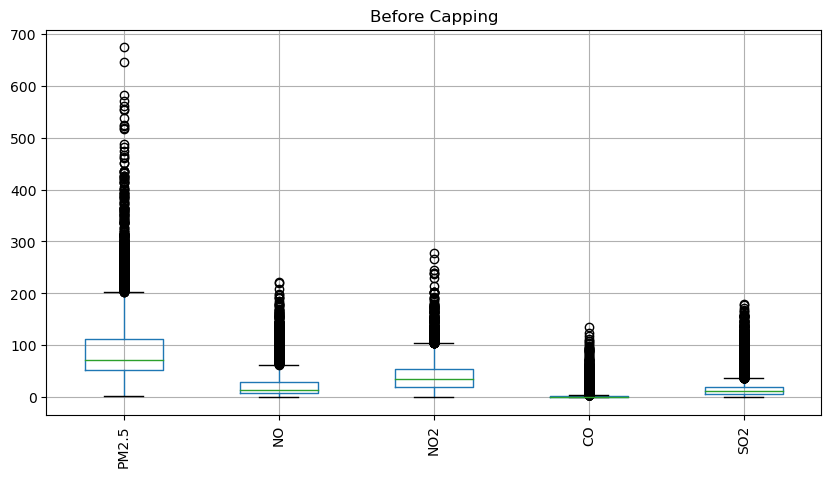

In [105]:
# Visual dari numerik yang masih ada outlier
plt.figure(figsize=(10,5))
X_train.boxplot(rot=90)
plt.title('Before Capping')
plt.show()

In [106]:
# First, capping the normal distribution
# Capping menggunakan metode IQR
winsoriser = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=['PM2.5', 'NO', 'NO2', 'CO', 'SO2']
                            )

X_train = winsoriser.fit_transform(X_train)

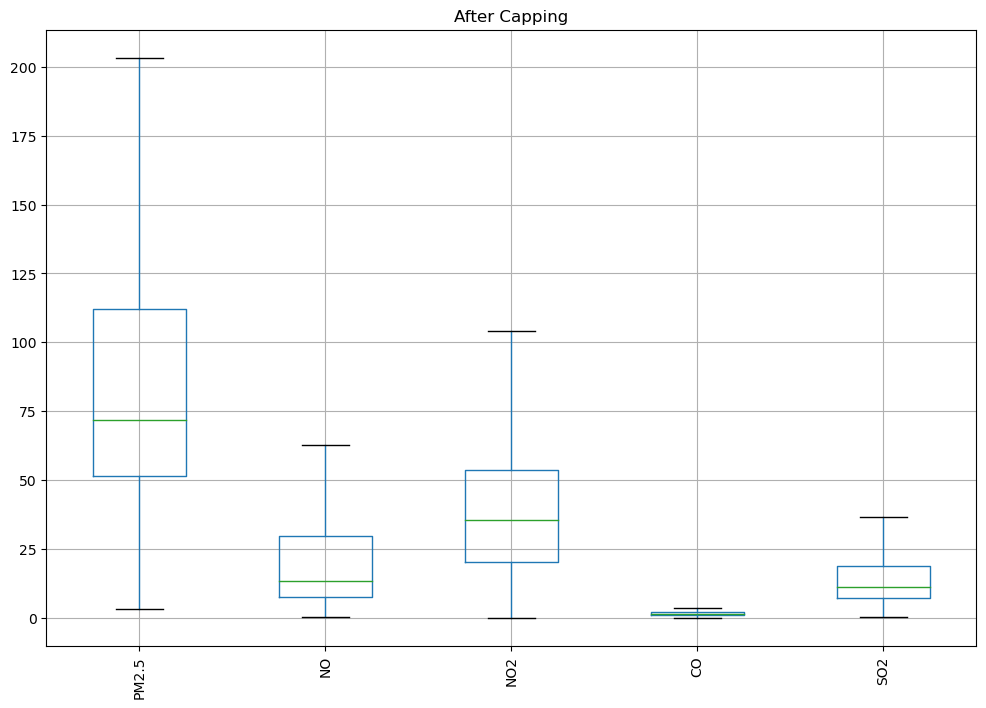

In [107]:
# Visual dari numerik Xtrain yang masih ada outlier
plt.figure(figsize=(12,8))
X_train.boxplot(rot=90)
plt.title('After Capping')
plt.show()

Setelah dilakukan handling outlier, feature tidak lagi memiliki outlier.

## 5.7 Balancing

In [108]:
# Mencari persentase value y train 
percentage = y_train.value_counts(normalize=True) * 100

print("\\nPersentase:")
print(percentage)

\nPersentase:
AQI_Bucket
1    54.487856
0    45.512144
Name: proportion, dtype: float64


In [109]:
# Sebelum handling imbalance
y_train.value_counts()

AQI_Bucket
1    4128
0    3448
Name: count, dtype: int64

Data target termasuk imbalanced, dikarenakan persentase target 1 'Good' lebih tinggi dibandingkan target 0 'Poor'. Untuk itu diperlukan handling imbalance. Handling imbalance dilakukan dengan tujuan agar model tidak cenderung memihak pada kelas mayoritas, sehingga nantinya model tidak efektif dalam memprediksi kelas minoritas. Atau alasan lain yaitu ketidakseimbangan kelas dapat menyebabkan risiko keputusan yang tidak seimbang dan evaluasi kinerja pada model menjadi bias.

Pada pengerjaan project ini akan dilakukan handling imbalance dengan metode undersampling. Under sampling dipilih dengan tujuan dapat mempercepat waktu pelatihan model dan dapat mengurangi risiko overfitting sehingga membantu model untuk lebih umum dan responsif terhadap kelas minoritas.

In [110]:
# Menggunakan NearMiss untuk under-sampling
nm = NearMiss(sampling_strategy='auto', n_neighbors=3, n_jobs=1, version=2)  # Pilih versi NearMiss yang sesuai
X_train, y_train = nm.fit_resample(X_train, y_train)

In [111]:
# Setelah handling imbalance
y_train.value_counts()

AQI_Bucket
0    3448
1    3448
Name: count, dtype: int64

Setelah dilakukan handling imbalance, data target sudah seimbang yaitu masing-masing berjumlah 3.448.

## 5.8 Scaling

Scalling dilakukan untuk menyesuaikan skala atau rentang nilai dari berbagai variabel agar seragam. Hal ini dilakukan untuk memastikan bahwa variabel-variabel dengan skala yang berbeda tidak memberikan pengaruh yang tidak seimbang pada model. Metode yang digunakan adalah Standard Scaler, digunakan StandardScaler sebab pada data sudah tidak memiliki outlier.

In [112]:
# Scaling Method menggunakan StandardScaler
scaler = StandardScaler()

# Define kolom numerical
scale_num_cols = ['PM2.5', 'NO', 'NO2', 'CO', 'SO2']

# Create ColumnTransfomer
preprocessing = ColumnTransformer(
    transformers=[
        ('scale', scaler, scale_num_cols), # scale kolom numerikal
    ])

# 6. MODEL DEFINITION

- Model KNN : KNeighborsRegressor adalah algoritma untuk memprediksi nilai kontinu dengan mempertimbangkan tetangga terdekat. Pengaturannya melibatkan n_neighbors dan weights.
- Model SVM : Support Vector Machine adalah algoritma yang dapat digunakan untuk tugas klasifikasi dan regresi.
- Model DecisionTree : DecisionTreeRegressor dalam machine learning dapat dijelaskan oleh kemampuannya dalam memodelkan hubungan nonlinier dan kompleks antara variabel dependen dan independen.
- Model RandomForest : RandomForestRegressor dalam konteks machine learning dapat dijelaskan oleh keunggulannya dalam mengatasi masalah overfitting yang seringkali terjadi pada DecisionTreeRegressor.
- Model XGBoost : eXtreme Gradient Boosting, adalah algoritma ensemble yang kuat dan efisien yang sering digunakan untuk klasifikasi dan regresi. XGBoost memadukan kekuatan DecisionTree ke dalam model yang lebih kuat dan toleran terhadap overfitting. 

In [113]:
# Definisi model KNN
pipe_knn = Pipeline([("preprocessor",preprocessing),('knn',KNeighborsClassifier())])

# Devinisi model SVM
pipe_svm = Pipeline([("preprocessor", preprocessing), ('svm', SVC())])

# Devinisi model DecisionTreeClassifier
pipe_tree = Pipeline([("preprocessor", preprocessing), ('tree', DecisionTreeClassifier())])

#Devinisi model RandomForestClassifier
pipe_rdf = Pipeline([("preprocessor", preprocessing), ('rdf', RandomForestClassifier())])

# Devinisi model XGBClassifier
pipe_xgb = Pipeline([("preprocessor", preprocessing), ('xgb', XGBClassifier())])

# 7. MODEL TRAINING AND EVALUATION

## 7.1 Cross Validation Base Model

Pemilihan metrics 'precision' bertujuan untuk mengevaluasi sejauh mana model dapat memberikan prediksi yang akurat terkait dengan kelas positif, yang dalam konteks Air Quality Index, dapat merujuk pada kualitas udara yang "Good" atau "Poor". Dalam konteks kasus prediksi Air Quality Index, metrics 'precision' dapat membantu mengukur seberapa akurat model dapat memprediksi kondisi udara yang sebenarnya buruk tapi terprediksi baik.

In [114]:
# set skfold
skfold = StratifiedKFold(n_splits=5)
# checking cross validation score
cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=skfold, scoring="precision")
cv_svm = cross_val_score(pipe_svm, X_train, y_train, cv=skfold, scoring="precision")
cv_tree = cross_val_score(pipe_tree, X_train, y_train, cv=skfold, scoring="precision")
cv_rdf = cross_val_score(pipe_rdf, X_train, y_train, cv=skfold, scoring="precision")
cv_xgb = cross_val_score(pipe_xgb, X_train, y_train, cv=skfold, scoring="precision")

model_name = []
cv_scores = 0
for cv,name in zip([cv_knn, cv_svm, cv_tree, cv_rdf, cv_xgb],['knn', 'svm', 'tree', 'rdf', 'xgb']):
    
    print(name)
    print('precision - All - Cross Validation  : ', cv)
    print('precision - Mean - Cross Validation : ', cv.mean())
    print('precision - Std - Cross Validation  : ', cv.std())
    print('precision - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        model_name = name
    else:
        pass
    
print('best model:', model_name)
print('cross-val mean:', cv_scores)

knn
precision - All - Cross Validation  :  [0.87989556 0.89728959 0.88461538 0.89787798 0.8879892 ]
precision - Mean - Cross Validation :  0.8895335440283846
precision - Std - Cross Validation  :  0.007060451266545712
precision - Range of Test-Set       :  0.8824730927618388 - 0.8965939952949303
--------------------------------------------------
svm
precision - All - Cross Validation  :  [0.87761194 0.90093708 0.88859764 0.89893617 0.87983979]
precision - Mean - Cross Validation :  0.8891845238888616
precision - Std - Cross Validation  :  0.009537404907767947
precision - Range of Test-Set       :  0.8796471189810936 - 0.8987219287966296
--------------------------------------------------
tree
precision - All - Cross Validation  :  [0.7260274  0.84400657 0.87517934 0.88010899 0.85646688]
precision - Mean - Cross Validation :  0.8363578348461378
precision - Std - Cross Validation  :  0.05666913649570386
precision - Range of Test-Set       :  0.779688698350434 - 0.8930269713418416
--------

Hasil dari cross validation yaitu model terbaik dalah RandomForest (rdf) dengan nilai 89%. Selanjutnya akan dilakukan evaluasi model RandomForest dengan cara hyperparameter tuning.

## 7.2 Hyperparameter Tuning Model Terbaik

Untuk melakukan hyperparameter tuning perlu diketahui default parameter dari model pilihan (RandomForest) terlebih dahulu. Default parameter tersebut dimasukkan untuk hyperparameter tuning dan digunakan untuk manjadi pembanding.

In [115]:
rdf = RandomForestClassifier()

# Base parameter model random forest
rdf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [116]:
params = [{
    'rdf__n_estimators': [10, 30, 50, 70],
    'rdf__max_depth': [None, 3, 5, 7, 10],
    'rdf__min_samples_split': [2, 5, 10],
    'rdf__min_samples_leaf': [1, 2, 4],
    'rdf__max_features': ['auto', 'sqrt', 'log2']
}]

rdf_grid = GridSearchCV(estimator=(pipe_rdf),
                         param_grid=params,
                         cv=5,
                         n_jobs=-1,
                         verbose=3,
                         scoring='precision')

rdf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=30;, score=nan total time=   0.0s
[CV 3/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END rdf__max_depth=None, rdf__max_features=auto, rdf__min_samples_leaf=1, rdf__min_samples_split=2, rdf__n_estimators=10;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['PM2.5',
                                                                          'NO',
                                                                          'NO2',
                                                                          'CO',
                                                                          'SO2'])])),
                                       ('rdf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'rdf__max_depth': [None, 3, 5, 7, 10],
                          'rdf__max_features': ['auto', 'sqrt', 'log2'],
                          'rdf__min_samples_leaf': [1, 2, 4],
                          'rdf__min_samples_split': [2, 5, 10],
                          'rdf__n_estimators': [10, 30, 50, 70]}],
             scoring='precision', verbose=3)

In [117]:
rdf_grid.best_params_

{'rdf__max_depth': 3,
 'rdf__max_features': 'sqrt',
 'rdf__min_samples_leaf': 4,
 'rdf__min_samples_split': 10,
 'rdf__n_estimators': 10}

In [118]:
rdf_grid.best_score_

0.9055764617516635

1. **Model Terbaik:**
   Model terbaik adalah Random Forest dengan hyperparameter:
   - Max depth: 3
   - Max features: 'sqrt'
   - Min samples leaf: 4
   - Min samples split: 10
   - Jumlah estimator: 10


2. **Kesimpulan:**
   - Model ini dipilih karena memberikan hasil paling baik dibanding opsi lain.
   - Max depth 3 menandakan kedalaman maksimal pohon keputusan dalam model.
   - Max features 'sqrt' menunjukkan jumlah fitur yang digunakan dalam setiap split.
   - Min samples leaf 4 dan min samples split 10 adalah jumlah minimum sampel yang dibutuhkan untuk membentuk leaf atau split.
   - Jumlah estimator 10 adalah jumlah pohon keputusan yang digunakan dalam model.


3. **Keunggulan Model Random Forest:**
   - Model Random Forest mampu memberikan prediksi dengan tingkat keakuratan yang sangat tinggi, dengan skor presisi mencapai 90.55%.
   - Penggunaan random forest dan teknik ensemble mengurangi risiko overfitting atau underfitting.
   - Hyperparameter yang dioptimalkan membantu model menjadi lebih efisien dan efektif.


4. **Kesimpulan Skor Tinggi:**
   - Skor presisi yang tinggi (90.55%) menunjukkan bahwa model mampu dengan akurat memprediksi hasil.
   - Hasil ini dapat diandalkan untuk memutuskan apakah kualitas udara Baik (Good) atau Buruk (Poor) dengan sangat baik.

In [119]:
# Save the best model we get from grid search
best_model = rdf_grid.best_estimator_

In [120]:
# Memprediksi nilai target pada data latih dan uji menggunakan model terbaik
y_train_pred = rdf_grid.predict(X_train)
y_test_pred = rdf_grid.predict(X_test)

# Menampilkan laporan klasifikasi untuk data latih
print("="*25,"TRAIN","="*25)
print(classification_report(y_train,y_train_pred))
print("\n")

# Menampilkan laporan klasifikasi untuk data uji
print("="*25,"TEST","="*25)
print(classification_report(y_test,y_test_pred))

========================= TRAIN =========================
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3448
           1       0.90      0.93      0.91      3448

    accuracy                           0.91      6896
   macro avg       0.91      0.91      0.91      6896
weighted avg       0.91      0.91      0.91      6896



========================= TEST =========================
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1419
           1       0.91      0.92      0.91      1828

    accuracy                           0.90      3247
   macro avg       0.90      0.90      0.90      3247
weighted avg       0.90      0.90      0.90      3247



Kesimpulan evaluasi model:

**Data Train** :
Akurasi keseluruhan model adalah 91%.
Untuk kelas 0 (Poor), presisi adalah 93%, recall adalah 89%, dan f1-score adalah 91%.
Untuk kelas 1 (Good), presisi adalah 90%, recall adalah 93%, dan f1-score adalah 91%.

**Data Test** :
Akurasi keseluruhan model adalah 90%.
Untuk kelas 0 (Poor), presisi adalah 89%, recall adalah 88%, dan f1-score adalah 89%.
Untuk kelas 1 (Good), presisi adalah 91%, recall adalah 92%, dan f1-score adalah 91%.

**Kesimpulan** :
- Model Random Forest memberikan hasil evaluasi yang cukup konsisten, baik pada data training maupun testing. Apabila dilihat dari score di atas, overall model RandomForest termasuk bestfit/goodfit.
- Precision score yang tinggi menunjukkan kemampuan model dalam memprediksi dengan akurat untuk kategori tertentu.
- Precision score pada test mengalami sedikit penurunan dalam memprediksi kategori 0 (Poor), hanya saja score pada test masih terbilang bagus.
- Akurasi yang tinggi (90%) menunjukkan keseluruhan kinerja model yang baik dalam klasifikasi 'AQI_Bucket'.

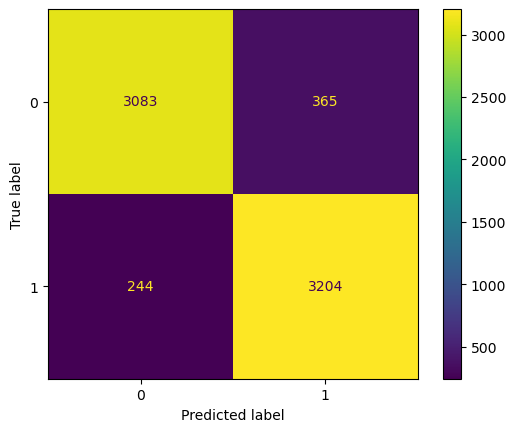

In [121]:
# Visualisasi confusion matrix - train set
confusionMatrixTrain = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusionMatrixTrain).plot()

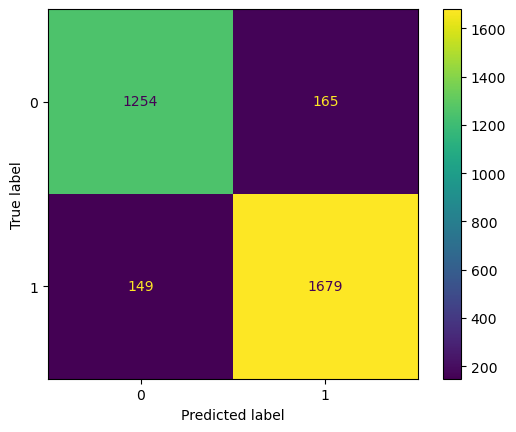

In [122]:
# Visualisasi confusion matrix - test set
confusionMatrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusionMatrix).plot()

Apabila dilihat dari gambar confusion matrix di atas, pada bagian train nilai False Positive (FP) berjumlah 365, sedangkan pada saat test jumlah False Positive (FP) berkurang menjadi 165.

# 9. MODEL SAVING

In [123]:
# Model Saving
# joblib.dump(best_model,'model.pkl')
with open("model.pkl", "wb") as file_1:
    pickle.dump(best_model, file_1)

# 10. MODEL INFERENCE

Ada di file 'P1M2_inf_permata_hajjarianti.ipynb'

# 11. KESIMPULAN

- Dataset terdiri dari 29.531 entris dan 16 kolom. Namun setelah dilakukan handling missing value, jumlah dataset yang digunakan yaitu 10.823 entries dan 13 kolom.

- Terdapat dua kategori pada target 'AQI_Bucket' yaitu 'Good' dan 'Poor'. Kategori Good diganti menjadi 1 dan kategori Poor diganti menjadi 0.

- Pada data train dipilih bebera kolom sebagai feature. Pemilihan feature menggunakan uji Pearson, Kendall, Cardinality dan Multicolinear (VIF). Adapun hasil feature selection adalah 'PM2.5', 'NO', 'NO2', 'CO', 'SO2'.

- Digunakan metrics precision dengan alasan ingin mengukur seberapa akurat model dapat memprediksi kondisi udara yang sebenarnya buruk (poor) tapi terprediksi baik (good).

- Model RandomForestRegressor memberikan kinerja yang baik dalam memprediksi kualitas udara kota-kota di India. Model RandomForestRegressor memberikan hasil precision sebesar 93% pada data train dan 89% pada data test untuk prediksi target 'Good'. Sedangkan hasil precision sebesar 90% pada data train dan 91% pada data test untuk prediksi target 'Poor'.

- Model RandomForestRegressor termasuk bestfit atau goodfit model.


-------------------------------------------------------------------------------------------------

## CONCEPTUAL PROBLEMS

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging!

Bootstrap Aggregating (bagging) dilakukan untuk meningkatkan akurasi dari model yang dibuat dengan cara menggabungkan hasil dari prediksi data training dari beberapa model yang dilatih secara acak. Cara kerja bagging adalah dengan cara membagi data secara acak pada data training lalu melatih model pada data acak tersebut dan kemudian mengambil prediksi akhir dari hasil penggabungan hasil prediksi detiap model.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih!

- Random Forest: Random Forest membuat beberapa "pilihan" secara acak dan kemudian memutuskan hasil akhir berdasarkan voting atau rata-rata dari "pilihan" tersebut.

- XGBoost: XGBoost membuat keputusan satu per satu, dan setiap keputusan dibuat untuk memperbaiki kekeliruan prediksi yang sebelumnya. Model ini terus belajar untuk memberikan prediksi yang lebih baik.

3. Jelaskan apa yang dimaksud dengan Cross Validation!

Cross Validation adalah suatu metode yang digunakan untuk melakukan pengujian terhadap performa suatu model dengan cara membagi terlebih dahulu data menjadi beberapa set. Setelah membagi data menjadi beberapa set, kemudian melatih model pada sebagian data set dan menguji pada data set yang tidak dilatih sehingga mendapatkan estimasi yang lebih baik tentang seberapa bagus model dapat digeneralisasi ke data baru.